# 👥 Customer Segmentation

This notebook performs customer segmentation using RFM analysis and K-Means clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Data path
DATA_PATH = Path('../../DataSource')
OUTPUT_PATH = Path('../outputs/predictions')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## 1. Load Data

In [2]:
# Load sales data
sales = pd.read_csv(DATA_PATH / 'Candy_Sales.csv')
sales['Order Date'] = pd.to_datetime(sales['Order Date'])

print(f"Loaded {len(sales)} transactions")
print(f"Unique customers: {sales['Customer ID'].nunique()}")
print(f"Date range: {sales['Order Date'].min()} to {sales['Order Date'].max()}")

Loaded 10194 transactions
Unique customers: 5044
Date range: 2021-01-03 00:00:00 to 2024-12-30 00:00:00


## 2. RFM Analysis

In [3]:
# Calculate RFM metrics
reference_date = sales['Order Date'].max() + pd.Timedelta(days=1)

rfm = sales.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print("RFM Summary:")
print(rfm.describe())

RFM Summary:
         Customer ID      Recency    Frequency     Monetary
count    5044.000000  5044.000000  5044.000000  5044.000000
mean   134650.256939   600.406622     1.694885    28.109364
std     20254.489438   419.470706     0.999844    27.412460
min    100006.000000     1.000000     1.000000     1.250000
25%    117236.500000   222.000000     1.000000    10.800000
50%    134295.500000   536.000000     1.000000    20.900000
75%    152255.750000   945.000000     2.000000    35.750000
max    192314.000000  1458.000000    15.000000   454.400000


In [4]:
# RFM Score (1-5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Combined RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("\nRFM Scores:")
rfm.head(10)


RFM Scores:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,100006,1211,1,11.25,1,1,2,112
1,100013,55,1,18.00,5,1,3,513
2,100041,407,3,21.25,4,5,3,453
3,100048,226,2,36.80,4,3,4,434
4,100055,217,2,18.30,4,3,3,433
5,100069,916,1,7.20,2,1,1,211
6,100083,403,1,3.60,4,1,1,411
7,100090,1272,1,29.25,1,1,4,114
8,100097,35,2,33.70,5,3,4,534
9,100111,102,5,182.41,5,5,5,555


In [5]:
# Define customer segments based on RFM
def segment_customer(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r <= 2 and f >= 4:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Lost'
    else:
        return 'Potential Loyalists'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Segment summary
segment_summary = rfm.groupby('Segment').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)
segment_summary.columns = ['Customers', 'Avg Recency', 'Avg Frequency', 'Avg Monetary', 'Total Revenue']
segment_summary = segment_summary.sort_values('Total Revenue', ascending=False)

print("Customer Segments:")
print(segment_summary.to_string())

Customer Segments:
                     Customers  Avg Recency  Avg Frequency  Avg Monetary  Total Revenue
Segment                                                                                
At Risk                    837      1049.33           2.58         44.46       37214.28
Champions                  605       184.01           2.86         56.34       34087.95
Loyal Customers           1187       366.08           1.81         26.69       31684.06
Potential Loyalists        804       785.13           1.12         17.72       14250.82
New Customers              827       179.21           1.00         15.25       12610.43
Lost                       784      1052.09           1.00         15.22       11936.09


## 3. K-Means Clustering

In [6]:
# Prepare data for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape: {X_scaled.shape}")

Data shape: (5044, 3)


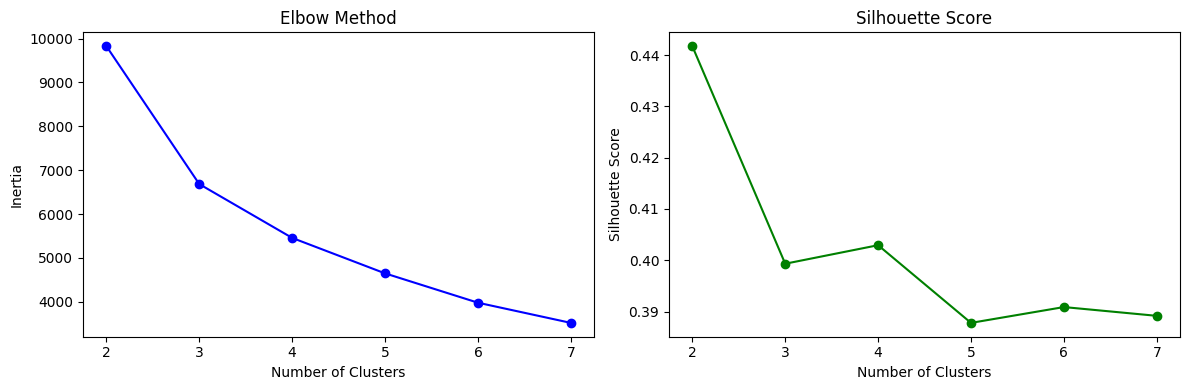


Best K by Silhouette: 2


In [7]:
# Find optimal K using Elbow method and Silhouette score
K_range = range(2, 8)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(K_range, silhouettes, 'go-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')

plt.tight_layout()
plt.show()

print(f"\nBest K by Silhouette: {K_range[np.argmax(silhouettes)]}")

In [8]:
# Final model with K=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster summary
cluster_summary = rfm.groupby('Cluster').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)
cluster_summary.columns = ['Customers', 'Avg Recency', 'Avg Frequency', 'Avg Monetary', 'Total Revenue']

print("K-Means Clusters:")
print(cluster_summary.to_string())

K-Means Clusters:
         Customers  Avg Recency  Avg Frequency  Avg Monetary  Total Revenue
Cluster                                                                    
0             2257       280.43           1.26         17.96       40536.59
1              940       577.33           2.96         52.06       48932.24
2             1696      1036.69           1.34         19.07       32339.36
3              151       626.48           4.26        132.29       19975.44


In [9]:
# Name clusters based on characteristics
cluster_names = {
    0: 'High Value',
    1: 'Active',
    2: 'New/Low',
    3: 'At Risk'
}

# Assign names based on monetary value ranking
cluster_monetary = rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=False)
name_mapping = {cluster: ['High Value', 'Active', 'Potential', 'Low Value'][i] 
                for i, cluster in enumerate(cluster_monetary.index)}
rfm['Cluster_Name'] = rfm['Cluster'].map(name_mapping)

print("\nCluster Distribution:")
print(rfm['Cluster_Name'].value_counts())


Cluster Distribution:
Cluster_Name
Low Value     2257
Potential     1696
Active         940
High Value     151
Name: count, dtype: int64


## 4. Visualization

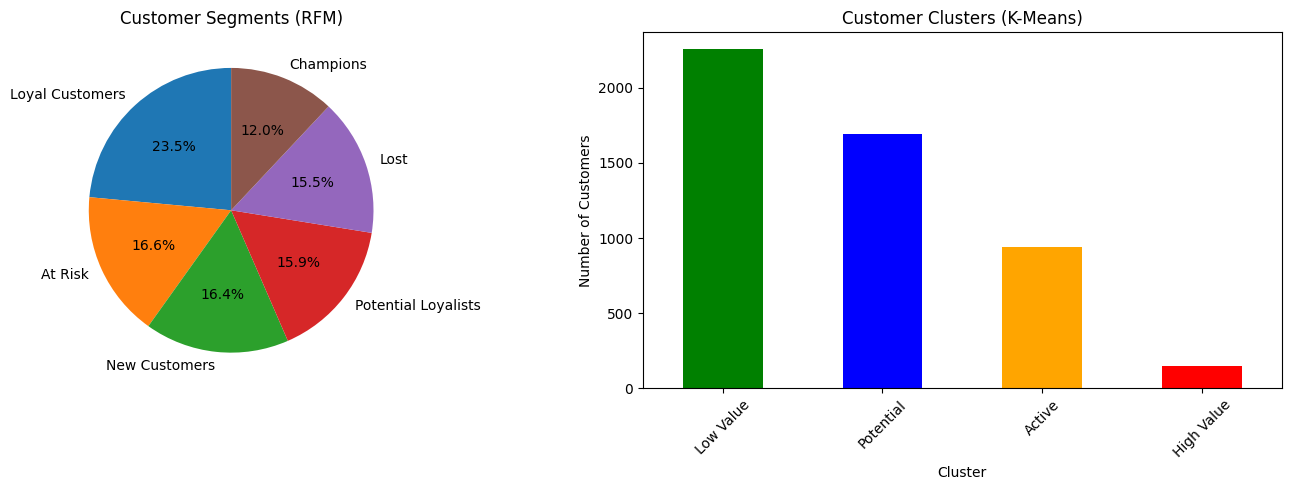

In [10]:
# RFM Segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment pie chart
segment_counts = rfm['Segment'].value_counts()
axes[0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Customer Segments (RFM)')

# Cluster bar chart
cluster_counts = rfm['Cluster_Name'].value_counts()
cluster_counts.plot(kind='bar', ax=axes[1], color=['green', 'blue', 'orange', 'red'])
axes[1].set_title('Customer Clusters (K-Means)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Customers')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

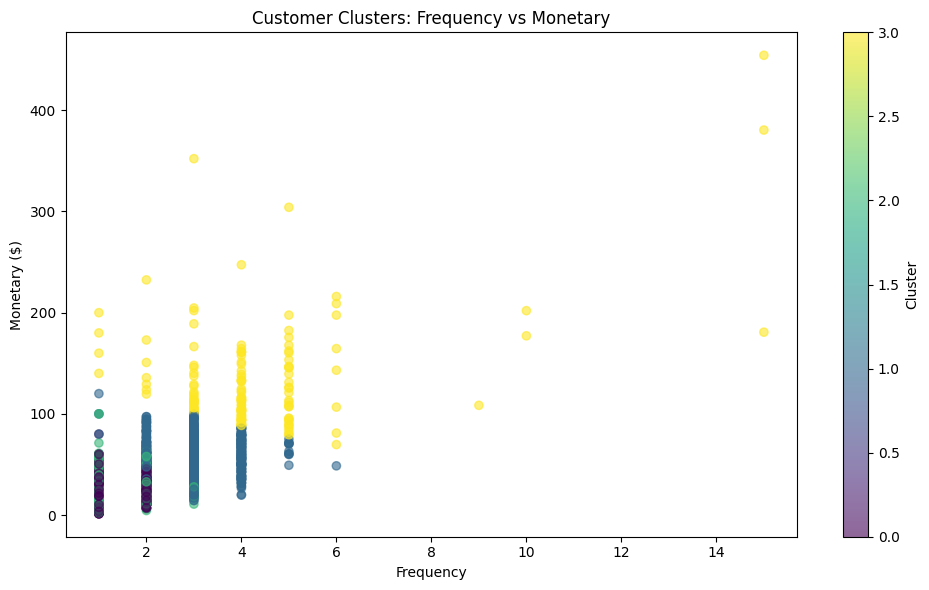

In [11]:
# Scatter plot of clusters
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(rfm['Frequency'], rfm['Monetary'], 
                     c=rfm['Cluster'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary ($)')
ax.set_title('Customer Clusters: Frequency vs Monetary')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

## 5. Export Results

In [12]:
# Export customer segments
output_cols = ['Customer ID', 'Recency', 'Frequency', 'Monetary', 
               'R_Score', 'F_Score', 'M_Score', 'Segment', 'Cluster', 'Cluster_Name']
rfm[output_cols].to_csv(OUTPUT_PATH / 'customer_segments.csv', index=False)

print(f"Saved customer segments to {OUTPUT_PATH / 'customer_segments.csv'}")
print(f"Total customers: {len(rfm)}")

Saved customer segments to ..\outputs\predictions\customer_segments.csv
Total customers: 5044


## 6. Business Recommendations

In [13]:
print("="*60)
print("CUSTOMER SEGMENTATION INSIGHTS")
print("="*60)

# Calculate key metrics
total_customers = len(rfm)
total_revenue = rfm['Monetary'].sum()

print("\n📊 SEGMENT BREAKDOWN:")
for segment in rfm['Segment'].unique():
    seg_data = rfm[rfm['Segment'] == segment]
    print(f"\n  {segment}:")
    print(f"    - Customers: {len(seg_data)} ({len(seg_data)/total_customers*100:.1f}%)")
    print(f"    - Revenue: ${seg_data['Monetary'].sum():,.0f} ({seg_data['Monetary'].sum()/total_revenue*100:.1f}%)")
    print(f"    - Avg Order Value: ${seg_data['Monetary'].mean():,.2f}")

print("\n💡 RECOMMENDATIONS:")
print("\n  Champions:")
print("    → VIP loyalty program")
print("    → Early access to new products")
print("    → Exclusive discounts")

print("\n  Loyal Customers:")
print("    → Upsell premium products")
print("    → Referral incentives")

print("\n  At Risk:")
print("    → Win-back campaigns")
print("    → Personalized offers")
print("    → Survey for feedback")

print("\n  New Customers:")
print("    → Welcome sequence")
print("    → First purchase discount")
print("    → Product education")

CUSTOMER SEGMENTATION INSIGHTS

📊 SEGMENT BREAKDOWN:

  Lost:
    - Customers: 784 (15.5%)
    - Revenue: $11,936 (8.4%)
    - Avg Order Value: $15.22

  New Customers:
    - Customers: 827 (16.4%)
    - Revenue: $12,610 (8.9%)
    - Avg Order Value: $15.25

  Loyal Customers:
    - Customers: 1187 (23.5%)
    - Revenue: $31,684 (22.3%)
    - Avg Order Value: $26.69

  Champions:
    - Customers: 605 (12.0%)
    - Revenue: $34,088 (24.0%)
    - Avg Order Value: $56.34

  At Risk:
    - Customers: 837 (16.6%)
    - Revenue: $37,214 (26.2%)
    - Avg Order Value: $44.46

  Potential Loyalists:
    - Customers: 804 (15.9%)
    - Revenue: $14,251 (10.1%)
    - Avg Order Value: $17.72

💡 RECOMMENDATIONS:

  Champions:
    → VIP loyalty program
    → Early access to new products
    → Exclusive discounts

  Loyal Customers:
    → Upsell premium products
    → Referral incentives

  At Risk:
    → Win-back campaigns
    → Personalized offers
    → Survey for feedback

  New Customers:
    → W